**Analiza błędów**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import tan, cos # dla obliczenia pojedyńczych wartości (niewektorowych) funkcji trygonometrycznych używam biblioteki math ponieważ jest szybsza niż numpy

Zadanie 1

In [15]:
from enum import Enum

# Definicja typów określających rodzaj różniczkowania
class DerivativeType(Enum):
    FORWARD = 1   # Różniczkowanie prawostronne (forward difference)
    CENTRAL = 2   # Różniczkowanie centralne (central difference)

class Ex1:
    _x : float              # Punkt, w którym obliczana jest pochodna funkcji
    _h_array : np.array     # Tablica wartości kroku h
    _x_array : np.array     # Tablica punktów (wszystkie równe x) do obliczeń numerycznych
    _der_type : str         # Typ różniczkowania (FORWARD lub CENTRAL)
    _eps = np.finfo(float).eps  # Epsilon precyzji dla typu float

    def __init__(self, x : float, h_array, der_type : DerivativeType):
        self._x = x
        self._h_array = np.array(h_array)
        self._x_array = np.array([x for _ in h_array])
        self._der_type = der_type

    def calculated_derivative(self) -> np.array:
        """
        Oblicza pochodną funkcji tan(x) metodą różnic skończonych
        w zależności od wybranego typu (FORWARD lub CENTRAL)
        """
        match self._der_type:
            case DerivativeType.FORWARD:
                # Obliczenie funkcji tan(x+h) dla każdego h
                f_x_h = np.tan(self._x_array + self._h_array)
                # Obliczenie funkcji tan(x) (w punkcie x)
                f_x = np.tan(self._x_array)
                # Obliczenie różnicy skończonej w przód
                return (f_x_h - f_x) / self._h_array
            case DerivativeType.CENTRAL:
                # Obliczenie funkcji tan(x+h) dla każdego h (prawa strona)
                f_r_h = np.tan(self._x_array + self._h_array)
                # Obliczenie funkcji tan(x-h) dla każdego h (lewa strona)
                f_l_h = np.tan(self._x_array - self._h_array)
                # Obliczenie różnicy skończonej centralnej
                return (f_r_h - f_l_h) / (2 * self._h_array)
        
    def _first_derivative(self) -> float:
        #Analityczna wartość pierwszej pochodnej funkcji tan(x)
        return 1 + tan(self._x)**2

    def _second_derivative(self) -> float:
        #Analityczna wartość drugiej pochodnej funkcji tan(x)
        return 2 * tan(self._x) / cos(self._x)
    
    def _third_derivative(self) -> float:
        #Analityczna wartość trzeciej pochodnej funkcji tan(x)
        return 2 * (1/cos(self._x))**4 + 4 * tan(self._x)**2 / cos(self._x)
    
    def real_derivative(self) -> np.array:
        # Tworzy tablicę z wartościami value rozmiaru tablicy _h_array
        value = self._first_derivative()
        return np.array([value for _ in self._h_array])

    def truncation_error(self) -> np.array:
        """
        Oblicza błąd przycięcia (truncation error) w przybliżeniu numerycznym
        w zależności od metody różniczkowania:
          - FORWARD: błąd przycięcia ~ (M * h) / 2, gdzie M jest wartością drugiej pochodnej
          - CENTRAL: błąd przycięcia ~ (M * h^2) / 6, gdzie M jest wartością trzeciej pochodnej
        """
        match self._der_type:
            case DerivativeType.FORWARD:
                M = self._second_derivative()
                return M * self._h_array / 2
            case DerivativeType.CENTRAL:
                M = self._third_derivative()
                return M * self._h_array**2 / 6
        
    def rounding_error(self) -> np.array:
        """
        Oblicza błąd zaokrągleń (rounding error) przy obliczeniach numerycznych,
        bazując na precyzji epsilon (_eps) oraz wielkości kroku h.
          - FORWARD: błąd ~ 2*eps/h
          - CENTRAL: błąd ~ eps/h
        """
        match self._der_type:
            case DerivativeType.FORWARD:
                return np.array([2*self._eps for _ in self._h_array]) / self._h_array
            case DerivativeType.CENTRAL:
                return np.array([self._eps for _ in self._h_array]) / self._h_array

    def abs_error(self, calc_values : np.array, true_values : np.array) -> np.array:
        #Oblicza bezwzględny błąd pomiędzy wartością przybliżoną a wartością prawdziwą.
        return np.abs(calc_values - true_values)

    def formula_h_min(self):
        """
        Oblicza teoretycznie optymalny krok h minimalizujący sumę błędu przycięcia i błędu zaokrągleń.
          - Dla metody FORWARD: h_min = 2 * (eps / |f''(x)|)^0.5
          - Dla metody CENTRAL: h_min = (3 * eps / |f'''(x)|)^(1/3)
        """
        match self._der_type:
            case DerivativeType.FORWARD:
                M = abs(self._second_derivative())
                return 2 * (self._eps / M)**0.5
            case DerivativeType.CENTRAL:
                M = abs(self._third_derivative())
                return (3 * self._eps / M)**(1/3)
    
    def empirical_h_min(self, abs_difference : np.array) -> float:
        """
        Wyznacza empirycznie krok h dla którego
        wartość bezwzględnej różnicy pomiędzy wartością numeryczną
        a analityczną (podana w abs_difference) jest najmniejsza.
        """
        idx_min = np.argmin(abs_difference)  # Znajdź indeks minimalnego błędu
        return self._h_array[idx_min]          # Zwróć odpowiadający krok h


Różnica prawostronna: 


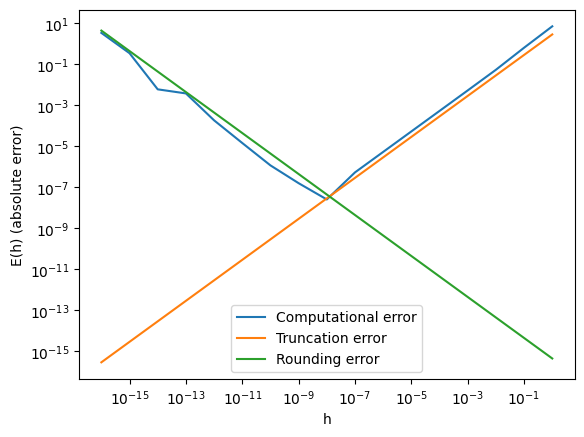

Empirycznie wyznaczona wartość h_min: 1e-08 | h_min z wzoru: 1.241230271785194e-08
Błąd względny: 19.43%
Minimalna wartość błędu bezwzględnego: 2.554135258847623e-08

----------------------------------------------------------------

Różnica centralna: 


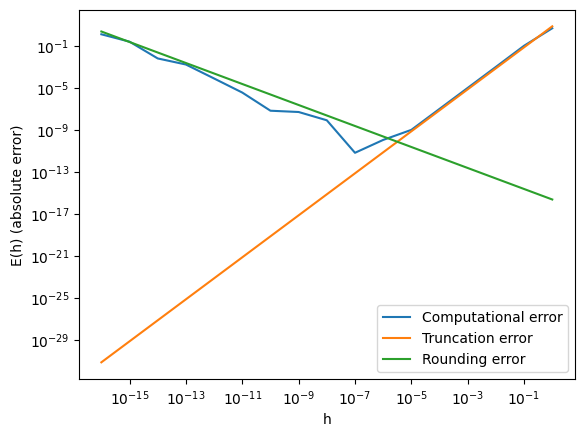

Empirycznie wyznaczona wartość h_min: 1e-07 | h_min z wzoru: 2.524057612604412e-06
Błąd względny: 96.04%
Minimalna wartość błędu bezwzględnego: 6.2230220976289274e-12


In [17]:
def method_test(method_type: DerivativeType):
    # Ustalenie punktu i tablicy wartości h
    x = 1
    k_array = [i for i in range(17)]
    h_array = [10**(-k) for k in k_array]
    
    # Inicjalizacja obiektu Ex1 z wybraną metodą różniczkowania
    func = Ex1(x, h_array, method_type)

    # Obliczenia: przybliżone metodycznie i analityczne wartości pochodnej oraz błędy
    calc_values = func.calculated_derivative()
    real_values = func.real_derivative()
    abs_difference = func.abs_error(calc_values, real_values)
    truncation_error = func.truncation_error()
    rounding_error = func.rounding_error()

    # Wyznaczenie optymalnego kroku h: empirycznie i teoretycznie
    empirical_h_min = func.empirical_h_min(abs_difference)
    theoretical_h_min = func.formula_h_min()

    # Rysowanie wykresu błędów na skali logarytmicznej dla obu osi
    plt.yscale("log")
    plt.xscale("log")
    plt.plot(h_array, abs_difference, label='Computational error')
    plt.plot(h_array, truncation_error, label='Truncation error')
    plt.plot(h_array, rounding_error, label='Rounding error')
    plt.xlabel("h")
    plt.ylabel("E(h) (absolute error)")
    plt.legend()
    plt.show()
    
    # Wyświetlenie minimum wyznaczonego empirycznie i teoretycznie
    print(f'Empirycznie wyznaczona wartość h_min: {empirical_h_min} | h_min z wzoru: {theoretical_h_min}')
    print(f'Błąd względny: {100 * abs(empirical_h_min - theoretical_h_min) / theoretical_h_min :.2f}%')
    print(f'Minimalna wartość błędu bezwzględnego: {np.min(abs_difference)}')
    
print("Różnica prawostronna: ")
method_test(DerivativeType.FORWARD)
print("\n----------------------------------------------------------------\n")
print("Różnica centralna: ")
method_test(DerivativeType.CENTRAL)


Zadanie 2

Zadanie 3

Zadanie 4